# Import VGG16 model, extract all the conv layer and pooling layer

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread, imresize

In [3]:
import os
import random

In [4]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16(weights='imagenet', include_top=True)
new_model = Model(input=model.input, 
                  output=model.get_layer('block5_pool').output)

In [ ]:
# shelve
import shelve

filename = 'tmp/shelve.out'
my_shelf = shelve.open(filename,'n')

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except :
        print 'ERROR shelving: {}'.format(key)
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: _sh
ERROR shelving: exit
ERROR shelving: f


In [ ]:
# unshelve
import shelve

filename = 'tmp/shelve.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    try:
        globals()[key] = my_shelf[key]
    except:
        print 'ERROR unshelving: {}'.format(key)
my_shelf.close()

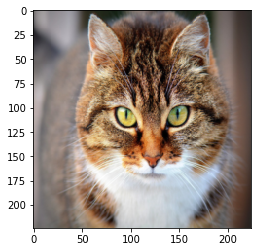

In [5]:
mean_pixel = [103.939, 116.779, 123.68]
mean_pixel = np.array(mean_pixel)
H = 224
W = 224

cat = imread('cat.jpg')
cat = imresize(cat,(W, H))
plt.imshow(cat)
plt.show()

In [6]:
cat = cat - mean_pixel
out = model.predict(cat[np.newaxis])

In [7]:
np.argmax(out)

281

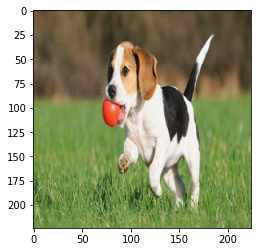

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [8]:
dog = imread('dog.jpg')
dog = imresize(dog, (W, H))
plt.imshow(dog)
plt.show(dog)

In [9]:
dog = dog - mean_pixel
out = model.predict(dog[np.newaxis])
np.argmax(out)

166

In [10]:
test_base = 'data/image/'
image_name_test = []
for file in os.listdir(test_base):
    if file.endswith('.jpg'):
        image_name_test.append(file)
len(image_name_test)

5063

In [11]:
image_num = len(image_name_test)
image_test = np.zeros((image_num, W, H, 3))

for i,file in enumerate(image_name_test):
    image = imread(test_base+file)
    image = imresize(image, (W, H))
    image_test[i] = image

In [12]:
out = new_model.predict(image_test-mean_pixel)

In [13]:
out.shape

(5063, 7, 7, 512)

In [14]:
out.sum(axis=(1,2)).shape

(5063, 512)

In [15]:
out = np.sum(out, axis=(1,2))

In [17]:
query_dir = 'data/gt_files_170407/'
query_list = []
for file in os.listdir(query_dir):
    if file.endswith('_query.txt'):
        query_list.append(file)
len(query_list)

55

(1, 20)


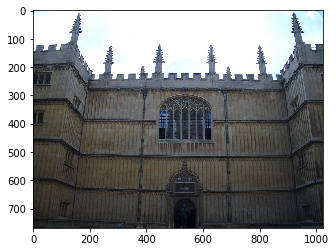

425


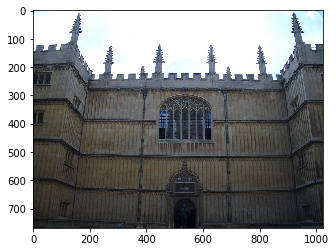

1828


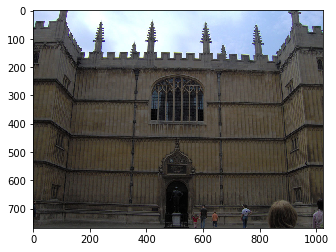

2946


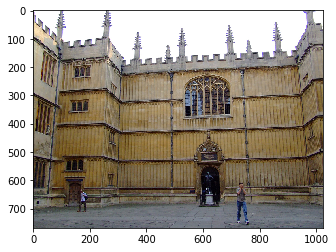

3075


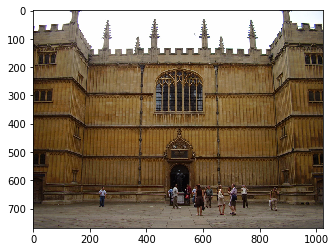

4012


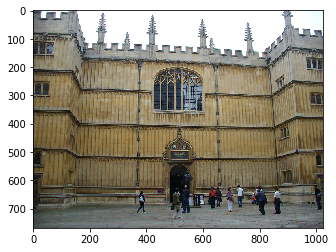

3586


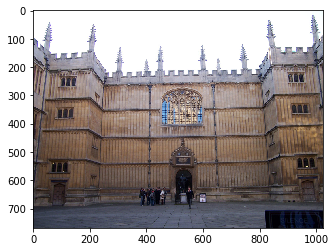

2660


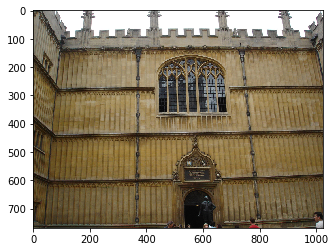

3017


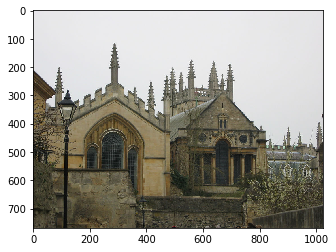

2073


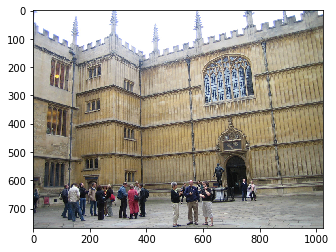

4005


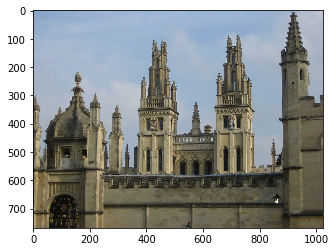

2356


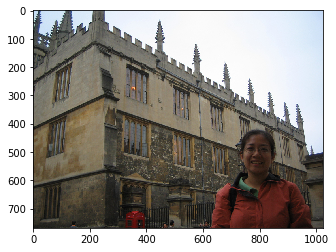

810


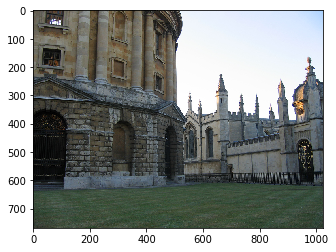

1136


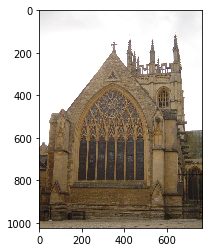

109


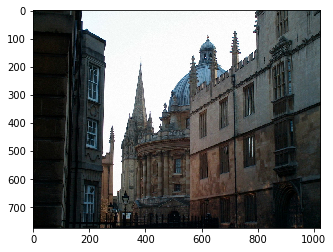

930


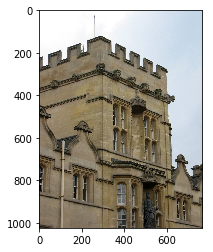

4167


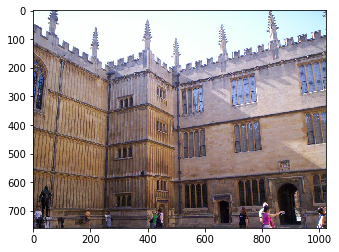

2045


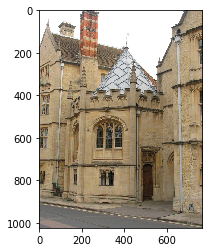

803


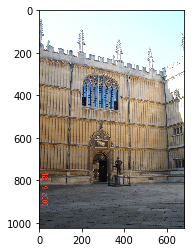

1389


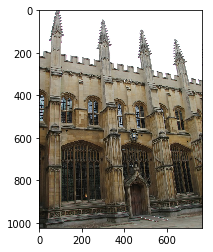

290


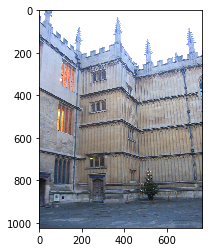

In [18]:
query = 'hertford_000027'
query = query + '.jpg'
index = image_name_test.index(query)
n_neighbors = 20

query = random.choice(query_list)
with open(query_dir+query) as f:
    query = f.read().split()[0]
    query = query[5:]
    query = query + '.jpg'
    
index = image_name_test.index(query)
    
from sklearn.neighbors import NearestNeighbors as NN
nn = NN()
nn.fit(out)
neighbors = nn.kneighbors(out[index][np.newaxis,:], n_neighbors=n_neighbors, 
                          return_distance=False)
print neighbors.shape

image = imread(test_base+image_name_test[index])
plt.imshow(image)
plt.show()

for neighbor in np.nditer(neighbors):
    # the first should be the query image
    print neighbor
    image = imread(test_base+image_name_test[neighbor])
    plt.imshow(image)
    plt.show()

In [19]:
def compute_ap(pos, amb, rank, debug = False):
    old_recall = 0.0
    old_precision = 1.0
    ap = 0.0
    
    intersect_size = 0
    i = 0
    j = 0
    
    for i in range(len(rank)):
        if rank[i] in amb:
            continue
        if rank[i] in pos:
            intersect_size += 1
        if False:
            # this is wrong
            recall = intersect_size / float(len(pos))
            precision = intersect_size / (j + 1.0)
            
            ap += (recall - old_recall) * ((old_precision + precision)/2.0)
            
            old_recall = recall
            old_precision = precision;
            j += 1
        else:
            if rank[i] in pos:
                ap0 = intersect_size / float(i+1.0)
                ap += ap0
                
                if debug:
                    print 'ap0'
                    print ap0
                    print 'min'
                    print min(float(len(pos)),len(rank))
    ap = ap / min(float(len(pos)),len(rank))
    return ap

In [20]:
compute_ap([1,2,3,4,5],[6,7,8],[2,1,3])

1.0

In [21]:
def load_list(file):
    with open(file, 'r') as f:
        l = []
        for line in f:
            l.append(line.rstrip('\n'))
        return l

In [22]:
def compute_ap2(query, rank, query_dir, debug=False):
    # here query is the name of picture, include .jpg
    query = query[:-10]
    good_set = load_list(query_dir+query+'_good.txt')
    ok_set = load_list(query_dir+query+'_ok.txt')
    junk_set = load_list(query_dir+query+'_junk.txt')
    
    pos_set = good_set + ok_set
    if debug:
        print 'pos_set'
        print pos_set
    
    ap = compute_ap(pos_set, junk_set, rank)
    return ap

In [23]:
query = 'hertford_000027'
query = query + '.jpg'
index = image_name_test.index(query)
n_neighbors = image_num/2

from sklearn.neighbors import NearestNeighbors as NN
nn = NN()
nn.fit(out)
neighbors = nn.kneighbors(out[index], n_neighbors=n_neighbors, 
                          return_distance=False)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [24]:
# convert the index to image name, meanwhile delete the first index because it is the query image
def i2name(l, d):
    l2 = []
    l = l.reshape(-1)
    l = l.tolist()
    if False:
        print 'len {}'.format(len(l))
    for item in l:        
        l2.append(d[item][:-4])
    return l2[1:]

In [25]:
def get_query_image(query, query_dir):
    with open(query_dir+query) as f:
        query = f.read().split()[0]
        query = query[5:]
        query = query + '.jpg'
    return query

In [37]:
def preprocessing(out, normalize=False, pca=-1, ica=-1, ica_iter=200):
    # ica_iter=200 is default value of FastICA
    if normalize:
        from sklearn.preprocessing import normalize as sknormalize
        out = sknormalize(out)
    
    if pca >= 0:
        from sklearn.decomposition import PCA
        pca = PCA(whiten=True)
        pca.fit(out)
        pca.transform(out)
        
    if ica >= 0:
        from sklearn.decomposition import FastICA
        ica = FastICA(max_iter=ica_iter)
        ica.fit(out)
        ica.transform(out)
    return out

In [27]:
def compute_neighbors(query, query_dir, image_name_test, out):
    # query    here query is the query file e.g XXXXX_query.txt
    query = get_query_image(query, query_dir)
    index = image_name_test.index(query)
    if False:
        print out.shape
    N, D = out.shape
    n_neighbors = image_num/2

    from sklearn.neighbors import NearestNeighbors as NN
    nn = NN()
    nn.fit(out)
    neighbors = nn.kneighbors(out[index][np.newaxis,:], n_neighbors=n_neighbors, 
                              return_distance=False)
    return neighbors

In [28]:
ap = []
name_dict = dict(enumerate(image_name_test))
for file in query_list:
    neighbors = compute_neighbors(file, query_dir, image_name_test, out)
    rank = i2name(neighbors, name_dict)
    ap0 = compute_ap2(file, rank, query_dir)
    ap.append(ap0)

In [29]:
np.mean(np.array(ap))

0.32217976011253585

In [30]:
query = random.choice(query_list)
neighbors = compute_neighbors(query, query_dir, image_name_test, out)
rank = i2name(neighbors, name_dict)
print 'query'
print query
print 'rank'
print rank[:20]
compute_ap2(query, rank, query_dir)

query
bodleian_5_query.txt
rank
['bodleian_000407', 'bodleian_000294', 'bodleian_000077', 'bodleian_000364', 'bodleian_000067', 'bodleian_000329', 'oxford_000781', 'bodleian_000258', 'radcliffe_camera_000293', 'bodleian_000249', 'radcliffe_camera_000403', 'oxford_001882', 'oxford_000160', 'jesus_000014', 'bodleian_000150', 'oxford_002482', 'oxford_002576', 'bodleian_000419', 'bodleian_000170', 'all_souls_000181']


0.340764830318139

# Adding Normalization

In [31]:
for file in query_list:
    features = preprocessing(out, normalize=True)
    neighbors = compute_neighbors(file, query_dir, image_name_test, features)
    rank = i2name(neighbors, name_dict)
    ap0 = compute_ap2(file, rank, query_dir)
    ap.append(ap0)
np.mean(np.array(ap))

0.34723933889988401

Adding normalization seems to degrade the performance

# Adding whiten and PCA

In [32]:
features = preprocessing(out, normalize=True, pca=0)
for file in query_list:
    neighbors = compute_neighbors(file, query_dir, image_name_test, features)
    rank = i2name(neighbors, name_dict)
    ap0 = compute_ap2(file, rank, query_dir)
    ap.append(ap0)
np.mean(np.array(ap))

0.35559253182899997

# Using ICA

In [33]:
out.max()

5244.2065

In [34]:
out.min()

0.0

In [39]:
features = preprocessing(out, ica=0, ica_iter=100)
for file in query_list:
    neighbors = compute_neighbors(file, query_dir, image_name_test, features)
    rank = i2name(neighbors, name_dict)
    ap0 = compute_ap2(file, rank, query_dir)
    ap.append(ap0)
np.mean(np.array(ap))

0.34287783585446013

ica_iter = 100   
MAP      = 0.34  
No improvement